In [25]:
from google.colab import files
uploaded = files.upload()  # Upload your ZIP file (e.g., data3a.zip)


Saving damaged_car2.jpeg to damaged_car2.jpeg


In [2]:
import zipfile

with zipfile.ZipFile("car_damage_severity_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [16]:
train_dir = "/content/data3a/training"
val_dir   = "/content/data3a/validation"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)


Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


In [17]:
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False  # Freeze the base model

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(base.input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    ModelCheckpoint("best_severity_model.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4703 - loss: 1.1784

44/44 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.4715 - loss: 1.1750 - val_accuracy: 0.6492 - val_loss: 0.7547 - learning_rate: 0.0010
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6079 - loss: 0.8190

44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6080 - loss: 0.8188 - val_accuracy: 0.6653 - val_loss: 0.7404 - learning_rate: 0.0010
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6373 - loss: 0.7626

44/44 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6375 - loss: 0.7625 - val_accuracy: 0.6976 - val_loss: 0.6787 - learning_rate: 0.0010
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6859 - loss: 0.7114 - val_accuracy: 0.6815 - val_loss: 0.7145 - learning_rate: 0.0010
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6692 - loss: 0.7513
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6693 - loss: 0.7508 - val_accuracy: 0.6694 - val_loss: 0.7057 - learning_rate: 0.0010
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.7008 - loss: 0.6868 - val_accuracy: 0.6815 - val_loss: 0.6997 - learning_rate: 3.0000e-04
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7050 - loss: 0.6669

44/44 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7048 - loss: 0.6669 - val_accuracy: 0.7016 - val_loss: 0.6700 - learning_rate: 3.0000e-04
Epoch 8/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7022 - loss: 0.6739 - val_accuracy: 0.6855 - val_loss: 0.7164 - learning_rate: 3.0000e-04
Epoch 9/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7105 - loss: 0.6585
Epoch 9: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7106 - loss: 0.6584 - val_accuracy: 0.6935 - val_loss: 0.6854 - learning_rate: 3.0000e-04
Epoch 10/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7347 - loss: 0.6223 - val_accuracy: 0.6976 - val_loss: 0.6859 - learning_rate: 9.0000e-05
Epoch 11/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7212 - loss: 0.6492
Epoch 11: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7210 - loss: 0.6493 - val_acc

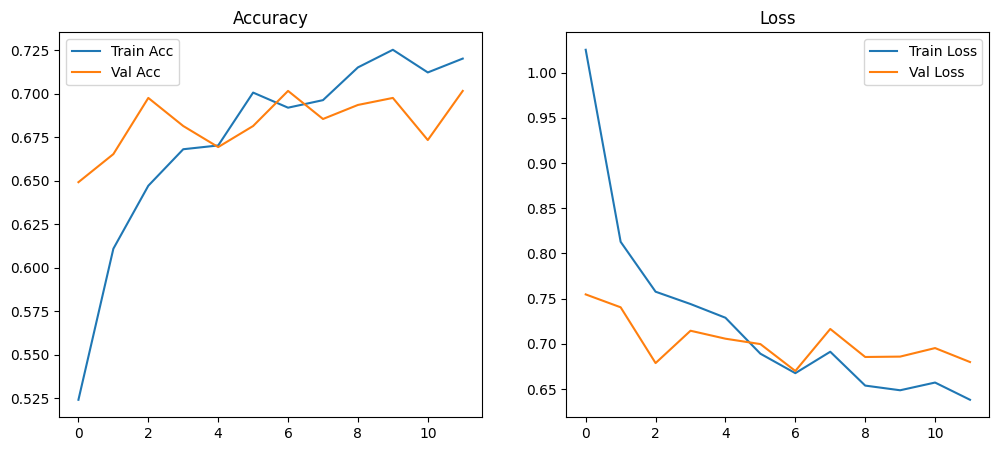

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [20]:
model.save("severity_model.h5")


In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load saved model
model = load_model("severity_model.h5")

# Load and preprocess image
img = image.load_img("/content/damaged_car2.jpeg", target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
classes = ['minor', 'moderate', 'severe']
print("Predicted:", classes[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: minor


In [27]:
pred = model.predict(img_array)[0]
for i, class_name in enumerate(['minor', 'moderate', 'severe']):
    print(f"{class_name}: {pred[i]*100:.2f}%")

print("Predicted:", ['minor', 'moderate', 'severe'][np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
minor: 97.24%
moderate: 2.68%
severe: 0.08%
Predicted: minor
